# Initialization

In [146]:
import numpy as np
from pprint import pprint


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup




descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=3,
    multiplex=True,
    number_multiplex=3,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="JW_KAIST",
    ip_address="192.168.0.83"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [147]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=True, do_emulation=False)
#session.disconnect()

[2025.09.09 23:18:54.048] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/laboneq_output/log
[2025.09.09 23:18:54.051] INFO    VERSION: laboneq 2.58.0
[2025.09.09 23:18:54.052] INFO    Connecting to data server at 192.168.0.83:8004


LabOneCoreError: Exception: Execution of connection to the data-server took longer than 10s.

In [3]:
from qpu_types import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform



_loaded_qubits = load_qubit_parameters(filename="latest") 
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = list(_loaded_qubits.values())

qubits = []
for i in range(3):
    q = TransmonQubit.from_logical_signal_group(
        f"q{i}",
        setup.logical_signal_groups[f"q{i}"],
        parameters=TransmonQubitParameters()
    )
    qubits.append(q)



qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()




from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


In [27]:
folder_store.deactivate()

BF 7

In [4]:
# 0 : 15 , 1 : 16 , 2 : 17, 3 : 18, 4 : 19
for q in qubits:
    #q.parameters.ge_drive_pulse["sigma"] = 0.25
    q.parameters.readout_amplitude = 1.0
    q.parameters.reset_delay_length = 20e-6

    q.parameters.readout_range_out = -10
    q.parameters.readout_range_in = 0
    q.parameters.drive_range = 10

    q.parameters.readout_lo_frequency = 7.6e9
    q.parameters.drive_lo_frequency = 4.8e9

    q.parameters.spectroscopy_length = 10e-6

    q.parameters.ge_drive_length =64e-9
    q.parameters.readout_integration_delay = None#####

 
qubits[0].parameters.resonance_frequency_ge = 4.8048e9
qubits[0].parameters.readout_resonator_frequency = 7.6267e9

qubits[1].parameters.resonance_frequency_ge = 4.5615e9
qubits[1].parameters.readout_resonator_frequency = 7.3094e9

qubits[2].parameters.drive_lo_frequency = 5.6e9
qubits[2].parameters.resonance_targ_frequency = 5.6e9
# qubits[2].parameters.resonance_frequency_ge = 4.716e9
# qubits[3].parameters.resonance_frequency_ge = 4.664e9
# qubits[4].parameters.resonance_frequency_ge = 4.779e9

# qubits[2].parameters.readout_resonator_frequency = 6.9226e9
# qubits[3].parameters.readout_resonator_frequency = 6.8433e9
# qubits[4].parameters.readout_resonator_frequency = 6.7739e9



3 oscillator to be calibrated
- `drive_local_osc`
- `readout_local_osc`
- `readout_acquire_osc`

In [5]:
from laboneq.dsl.calibration import Calibration, Oscillator, SignalCalibration

sibal= SignalCalibration()
sibal.delay_signal

In [6]:
from experiments import signal_propagation_delay
options = signal_propagation_delay.experiment_workflow.options()
#workflow.show_fields(options)

Correcting propagation delay. 

$\Delta \phi =-2\pi f t$ $\implies$ $\tau = \frac{1}{\Delta f}$

In [7]:
from experiments import signal_propagation_delay
####################################################################################
qubits[0].parameters.readout_amplitude =1.0
q=qubits[0]
delays=np.linspace(0e-9, 200e9, 51)
measure_delays = 40e-6
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#####################################################################################
options = signal_propagation_delay.experiment_workflow.options()
#workflow.show_fields(options)
options.update(False)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
prop_delay = signal_propagation_delay.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    delays=delays,
    measure_delay=measure_delays,
    options=options
)
prop_delay_result=prop_delay.run()
prop_delay_analysis_result = prop_delay_result.tasks["analysis_workflow"]
pprint(prop_delay_analysis_result.output)

('measure',
 {'amplitude': 1.0,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
DRIVE range (dBm) : 10, READOUT range (dBm) : -10
[2025.09.09 17:21:11.844] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:21:11.846] INFO      Workflow 'experiment_workflow': execution started at 2025-09-09               
[2025.09.09 17:21:11.847] INFO      08:21:11.844209Z                                                              
[2025.09.09 17:21:11.847] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:21:11.891] INFO    Task 'create_experiment': started at 2025-09-09 08:21:11.891360Z
[2025.09.09 17:21:11.906] INFO    Task 'create_experiment': ended at 2025-09-09 08:21:11.906515Z
[2025.09.09 17:21:11.911] INFO    Task 'compile_experiment': started at 2025-09-09 08:21:11.911623Z
[2025.09.09 17:21:11.915] INFO  

[2025.09.09 17:21:12.706] CRITICAL Maximum delay via SHFQC/QA:dev12256:qa0's node is 131070.00 ns - for larger values, use the delay_signal property.


[2025.09.09 17:21:12.824] ERROR   Task 'run_experiment': failed at 2025-09-09 08:21:12.824328Z with: 


[2025.09.09 17:21:12.824] ERROR   Task 'run_experiment': failed at 2025-09-09 08:21:12.824328Z with: 


[2025.09.09 17:21:12.825] ERROR   LabOneQControllerException("Maximum delay via SHFQC/QA:dev12256:qa0's node is 


[2025.09.09 17:21:12.825] ERROR   LabOneQControllerException("Maximum delay via SHFQC/QA:dev12256:qa0's node is 


[2025.09.09 17:21:12.825] ERROR   131070.00 ns - for larger values, use the delay_signal property.")


[2025.09.09 17:21:12.825] ERROR   131070.00 ns - for larger values, use the delay_signal property.")


[2025.09.09 17:21:12.826] INFO    Task 'run_experiment': ended at 2025-09-09 08:21:12.826273Z
[2025.09.09 17:21:12.827] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:21:12.827] INFO      Workflow 'experiment_workflow': execution ended at 2025-09-09                 
[2025.09.09 17:21:12.827] INFO      08:21:12.826859Z                                                              
[2025.09.09 17:21:12.827] INFO     ────────────────────────────────────────────────────────────────────────────── 


LabOneQControllerException: Maximum delay via SHFQC/QA:dev12256:qa0's node is 131070.00 ns - for larger values, use the delay_signal property.

[2025.09.09 17:21:17.834] INFO    Starting near-time execution...
[2025.09.09 17:21:18.160] INFO    Finished near-time execution.


In [ ]:
prop_delay_analysis_result.tasks["plot_data"].output['q0']

# 1. Spectroscopy

In [ ]:

qubits[1].parameters.drive_range = 10
qubits[1].parameters.readout_range_out= -10

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=0, amplitude=0.001,attenuation=[])

### 1.1 Resonator spectroscopy with amplitude sweep

STRATEGY
1. CW spectroscpy for wide range scan
    * CW spectroscopy can be done for wide range scan 
    * amplitude, frequency 2D sweep 을 통해  power에 따른 broadening 및 SNR 경향 관찰
    * $\Delta F$ : frequency span,  $\Delta f_r$
    * Pick $\Delta F / \Delta f_r$ 1~2

In [ ]:
from experiments import resonator_spectroscopy_amplitude

####################################################################################
qubits[1].parameters.readout_amplitude =1.0
q=qubits[1]
pprint(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,101)
amplitudes = np.linspace(0.0, 1.0, 21) #This works as scaling factor!!!!!!!!!!!!
#####################################################################################
options = resonator_spectroscopy_amplitude.experiment_workflow.options()
#workflow.show_fields(options)
options.update(False)
options.use_cw(False)
options.do_analysis(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec_amp = resonator_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)
res_spec_amp_result=res_spec_amp.run()


In [ ]:
res_spec_amp_result.tasks["analysis_workflow"].tasks["plot_signal_magnitude_and_phase_2d"].output["q0"]

### 1.2 Resonator Spectroscopy
* CW not recommended 

In [ ]:
qubits[0].parameters.readout_integration_delay 
qubits[0].parameters.readout_integration_kernels_type

In [ ]:
qubits[0].readout_integration_parameters()

In [ ]:
from experiments import resonator_spectroscopy

####################################################################################
q=qubits[1]
q.parameters.readout_amplitude = 1.0
print(q.readout_parameters())
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,501)
frequencies = q.parameters.readout_resonator_frequency + np.linspace(-10e6,10e6,1001)
#####################################################################################
options = resonator_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(1024)
options.update(True)
options.use_cw(False) #qop.measure 
options.fit_complex_resonator(False)
options.fit_lorentzian(True)
######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
res_spec = resonator_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=options
)
res_spec_result = res_spec.run()
res_spec_analysis_result = res_spec_result.tasks["analysis_workflow"]
pprint(res_spec_analysis_result.output)

In [ ]:
res_spec_analysis_result.tasks['plot_magnitude_phase'].output

In [ ]:
# res_spec_result.tasks["analysis_workflow"].tasks["plot_real_imaginary"].output

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

#show_pulse_sheet(compiled_experiment=res_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=res_spec_result.tasks["compile_experiment"].output)

### 2.1 Qubit Spectroscopy with Amplitude Sweep
* Current qubit spectroscopy modules do not support CW 
* Recommended to use long enough spectroscopy drive (pulsed) to see steady state signals

In [ ]:
from experiments import qubit_spectroscopy_amplitude

###############################################################
q = qubits[1]
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-2e6, 2e6, 101)
amplitudes = np.linspace(0.01, 1.0, 11)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")

pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy_amplitude.experiment_workflow.options()
options.update(False)
# workflow.show_fields(options)
###################################################################
qubit_spec_amp = qubit_spectroscopy_amplitude.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)

qubit_spec_amp_result = qubit_spec_amp.run()
qubit_spec_amp_result

### 2.2 Qubit Spectroscopy 


In [ ]:
from experiments import qubit_spectroscopy

qubits[1].parameters.resonance_frequency_ge = 4.5615e9
###############################################################
q = qubits[1]
q.parameters.spectroscopy_amplitude = 1.0
q.parameters.readout_amplitude = 1.0
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-3e6, 3e6, 51)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
pprint(q.spectroscopy_parameters())
################################################################
options = qubit_spectroscopy.experiment_workflow.options()
options.update(True)
options.count(1024*4)
# workflow.show_fields(options)
###################################################################
qubit_spec = qubit_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    options=options
)

qubit_spec_result = qubit_spec.run()
qubit_spec_result

# 2. Rabi

## 2.1 Rabi Amplitude 

In [ ]:
qubits[1].parameters.ge_drive_amplitude_pi = 1.0

In [ ]:
qubits[1].parameters.drive_range = 10

In [10]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[0]

#######################################################################
amplitudes = np.linspace(0.02, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(True)
options.use_cal_traces(True)
options.do_pca(False)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

0.666112479044798
DRIVE range (dBm) : 10, READOUT range (dBm) : -10
[2025.09.09 17:23:10.582] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:23:10.583] INFO      Workflow 'amplitude_rabi': execution started at 2025-09-09 08:23:10.582490Z   
[2025.09.09 17:23:10.584] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:23:10.596] INFO    Task 'temporary_qpu': started at 2025-09-09 08:23:10.596482Z
[2025.09.09 17:23:10.597] INFO    Task 'temporary_qpu': ended at 2025-09-09 08:23:10.597257Z
[2025.09.09 17:23:10.599] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-09-09 
[2025.09.09 17:23:10.599] INFO    08:23:10.599121Z
[2025.09.09 17:23:10.600] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-09-09 08:23:10.599985Z
[2025.09.09 17:23:10.601] INFO    Task 'create_experiment': started at 2025-09-09 08:23:10.601037Z
[2025.09.09 17:23:10.606] INFO   

## 2.2 (optional) Rabi Amplitude Chevron 

In [ ]:
from experiments import amplitude_rabi_chevron

#######################################################################
q = qubits[0]
amplitudes = np.linspace(0,1.0,11)
frequencies = q.parameters.resonance_frequency_ge + np.linspace(-3e6, 3e6, 51)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi_chevron.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
rabi_amp_chev = amplitude_rabi_chevron.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    frequencies=frequencies,
    amplitudes=amplitudes,
    options=options
)

rabi_amp_chev_result = rabi_amp_chev.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_chev_result.tasks['analysis_workflow'].output)


## 2.3 (optional) Rabi Length
- Not working yet

In [ ]:
# from experiments import time_rabi
# #######################################################################
# q = qubits[2]
# q.parameters.ge_drive_amplitude_pi = 0.3
# lengths = np.linspace(0.0, 240e-9, 21 ),
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = time_rabi.experiment_workflow.options()

# #print(workflow.show_fields(options))

# ###################################################################
# rabi_length = time_rabi.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     lengths=lengths,
#     options=options
# )

# rabi_length_result = rabi_length.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_length_result.tasks['analysis_workflow'].output)


## 2.2 (optional) Rabi Length Chevron

In [ ]:
# from experiments import time_rabi_chevron
# #######################################################################
# q = qubits[4]

# frequencies = q.parameters.resonance_frequency_ge + np.linspace(-5e6, 5e6, 21)
# lengths = np.linspace(0.0, 240e-9, 21 ),
# print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
# #######################################################################
# options = time_rabi_chevron.experiment_workflow.options()

# #print(workflow.show_fields(options))

# ###################################################################
# rabi_length_chev = time_rabi_chevron.experiment_workflow(
#     session=session,
#     qpu=qpu,
#     qubits=q,
#     frequencies=frequencies,
#     lengths=lengths,
#     options=options
# )

# rabi_length_chev_result = rabi_length_chev.run()
# #qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
# print(rabi_length_chev_result.tasks['analysis_workflow'].output)


# 3. Ramsey

In [12]:
from experiments import ramsey

q = qubits[0]
#######################################################################
delays = np.linspace(0,6e-6,301)
detunings = 0.7e6
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)

('measure',
 {'amplitude': 1.0,
  'length': 2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2025.09.09 17:25:20.728] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:25:20.728] INFO      Workflow 'ramsey': execution started at 2025-09-09 08:25:20.727722Z           
[2025.09.09 17:25:20.728] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:25:20.743] INFO    Task 'temporary_qpu': started at 2025-09-09 08:25:20.742898Z
[2025.09.09 17:25:20.744] INFO    Task 'temporary_qpu': ended at 2025-09-09 08:25:20.744593Z
[2025.09.09 17:25:20.746] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-09-09 
[2025.09.09 17:25:20.747] INFO    08:25:20.746655Z
[2025.09.09 17:25:20.747] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-09-09 08:25:20.747666Z
[2025.09.09 17:25:20.748] INFO    Task

In [13]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[0]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

[2025.09.09 17:27:43.037] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:27:43.038] INFO      Workflow 'experiment_workflow_x180': execution started at 2025-09-09          
[2025.09.09 17:27:43.038] INFO      08:27:43.036892Z                                                              
[2025.09.09 17:27:43.039] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:27:43.043] WARNING Type <class 'dict'> has unsupported keys or values. Keys must be strings and values must have one of the following types: [NoneType, int, float, complex, bool, str, dict, list, tuple, integer, ndarray] [name: experiment_workflow_x180.input.temporary_parameters].
[2025.09.09 17:27:43.055] INFO    Task 'temporary_qpu': started at 2025-09-09 08:27:43.055755Z
[2025.09.09 17:27:43.056] WARNING Type <class 'dict'> has unsupported keys or values. Keys must be strings and values must have one of the following

In [21]:
folder_store.activate()

# x90

In [25]:
from laboneq_applications.experiments import amplitude_fine
q = qubits[0]
temporary_parameters = q.parameters.copy()

#######################################################################
repetitions =np.arange(1,20)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters={q.uid : temporary_parameters},
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

[2025.09.09 17:57:29.514] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:57:29.515] INFO      Workflow 'experiment_workflow_x90': execution started at 2025-09-09           
[2025.09.09 17:57:29.515] INFO      08:57:29.514172Z                                                              
[2025.09.09 17:57:29.516] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:57:29.521] WARNING Type <class 'dict'> has unsupported keys or values. Keys must be strings and values must have one of the following types: [NoneType, int, float, complex, bool, str, dict, list, tuple, integer, ndarray] [name: experiment_workflow_x90.input.temporary_parameters].
[2025.09.09 17:57:29.530] INFO    Task 'temporary_qpu': started at 2025-09-09 08:57:29.530348Z
[2025.09.09 17:57:29.531] WARNING Type <class 'dict'> has unsupported keys or values. Keys must be strings and values must have one of the following 

In [24]:
from laboneq_applications.experiments import drag_q_scaling
q = qubits[1]
temporary_parameters = q.parameters.copy()

#######################################################################
q_scalings = np.linspace(-0.1,0.1,51)
#######################################################################
options = drag_q_scaling.experiment_workflow.options()
options.update(False)



#print(workflow.show_fields(options))

###################################################################
drag = drag_q_scaling.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    q_scalings=q_scalings,
    options=options
)

drag_result = drag.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(drag_result.tasks['analysis_workflow'].output)

[2025.09.09 17:57:01.949] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:57:01.949] INFO      Workflow 'drag_q_scaling': execution started at 2025-09-09 08:57:01.948749Z   
[2025.09.09 17:57:01.950] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:57:01.965] INFO    Task 'temporary_qpu': started at 2025-09-09 08:57:01.964916Z
[2025.09.09 17:57:01.966] INFO    Task 'temporary_qpu': ended at 2025-09-09 08:57:01.965950Z
[2025.09.09 17:57:01.968] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-09-09 
[2025.09.09 17:57:01.968] INFO    08:57:01.967952Z
[2025.09.09 17:57:01.969] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-09-09 08:57:01.968928Z
[2025.09.09 17:57:01.970] INFO    Task 'create_experiment': started at 2025-09-09 08:57:01.970071Z
[2025.09.09 17:57:01.975] INFO    Task 'create_experiment': ended at 2025-09-09 08:57:01.975565Z
[202

# RIP

This notebook is dedicated to TG's RIP gate calibration

### Current issues

1. phase sweep for detuning is not implemented 
2. First prepare state section takes 80ns length for unknown reason (might be related to port delay calibration setting)
3. Folderstore not working... 

In [ ]:
qubits[2].parameters.resonance_targ_frequency
qubits[2].parameters.drive_lo_frequency

In [121]:
from experiments import rip

q = qubits[1]
temporary_parameters = q.parameters.copy()

#######################################################################

#######################################################################
options = rip.experiment_workflow.options()
options.update(False)



#print(workflow.show_fields(options))

###################################################################
rip_drive = rip.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=qubits[1],
    targ=qubits[0],
    bus=qubits[2],
    ctrl_state="e",
    delays=np.linspace(300e-9, 2000e-9,101),
    detunings=0.0e6,
    frequencies=qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6),
    amplitude=0.6,
    options=options
)

rip_result = rip_drive.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
#print(drag_result.tasks['analysis_workflow'].output)

[2025.09.09 18:23:03.704] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 18:23:03.704] INFO      Workflow 'rip': execution started at 2025-09-09 09:23:03.703921Z              
[2025.09.09 18:23:03.705] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 18:23:03.706] INFO    Task 'temporary_qpu': started at 2025-09-09 09:23:03.706348Z
[2025.09.09 18:23:03.708] INFO    Task 'temporary_qpu': ended at 2025-09-09 09:23:03.708081Z
[2025.09.09 18:23:03.709] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-09-09 
[2025.09.09 18:23:03.710] INFO    09:23:03.709552Z
[2025.09.09 18:23:03.711] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-09-09 09:23:03.710842Z
[2025.09.09 18:23:03.711] INFO    Task 'create_experiment': started at 2025-09-09 09:23:03.711464Z
swp_delays: SweepParameter(uid='wait_time_q0', values=[3e-07, 3.17e-07, 3.34e-07, 3.51e-07, 3.6799999

In [90]:
qubits[2].parameters.resonance_targ_frequency = 5.6e9
qubits[2].parameters.resonance_targ_frequency

5600000000.0

In [ ]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=rip_result.tasks["compile_experiment"].output,name='test', interactive=False, max_events_to_publish=100000)
#plot_simulation(compiled_experiment=rip_result.tasks["compile_experiment"].output)

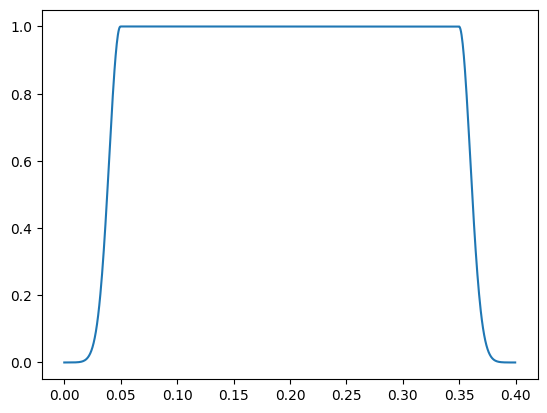

In [ ]:
# import matplotlib.pyplot as plt
# from qpu_types.Transmon.operations import create_pulse
# bus = qubits[2]
# drive_line, params = bus.cr_parameters() #bus element의 cr_parameters!!!
# length =300e-9
# override_params = {'length': 400e-9 ,'risefall_sigma_ratio': None, 'width': 400e-9 - 2*50e-9}            
# cr_pulse = create_pulse(parameters=params["pulse"], overrides=override_params, name="cr_pulse") #overides pulse_parameters

# time, wfm = cr_pulse.generate_sampled_pulse()
# plt.plot(time*1e6, wfm.real)

In [132]:
from laboneq.simple import save, load

save(rip_result.output, filename='0909n_e_0.6')
load(filename='0909n_e_0.6')

Results(
│   errors=[],
│   data=AttributeWrapper(
│   │   q0=AttributeWrapper(
│   │   │   cal_trace=AttributeWrapper(
│   │   │   │   e=AcquiredResult(
│   │   │   │   │   handle='q0/cal_trace/e',
│   │   │   │   │   axis_name=[],
│   │   │   │   │   axis=[],
│   │   │   │   │   data=np.complex128(0.5965264651697246-0.0907640398512108j),
│   │   │   │   │   last_nt_step=[]
│   │   │   │   ),
│   │   │   │   g=AcquiredResult(
│   │   │   │   │   handle='q0/cal_trace/g',
│   │   │   │   │   axis_name=[],
│   │   │   │   │   axis=[],
│   │   │   │   │   data=np.complex128(-0.28410469034070474+0.4315700984785523j),
│   │   │   │   │   last_nt_step=[]
│   │   │   │   )
│   │   │   ),
│   │   │   result=AcquiredResult(
│   │   │   │   handle='q0/result',
│   │   │   │   axis_name=[
│   │   │   │   │   'rip_freq_q0',
│   │   │   │   │   'wait_time_q0'
│   │   │   │   ],
│   │   │   │   axis=[
│   │   │   │   │   array([5.590e+09, 5.594e+09, 5.598e+09, 5.602e+09, 5.606e+09, 5.610e+09]),
│   

In [123]:
from laboneq_applications.analysis.calibration_traces_rotation import (
    calculate_qubit_population_2d,
    calculate_qubit_population
)
targ= qubits[0]
delays=np.linspace(300e-9, 2000e-9,101)
frequencies = qubits[2].parameters.resonance_targ_frequency + np.linspace(-10e6,10e6,6)
processed_d=calculate_qubit_population_2d(qubits=targ, result=rip_result.output, sweep_points_1d=delays, sweep_points_2d=frequencies)

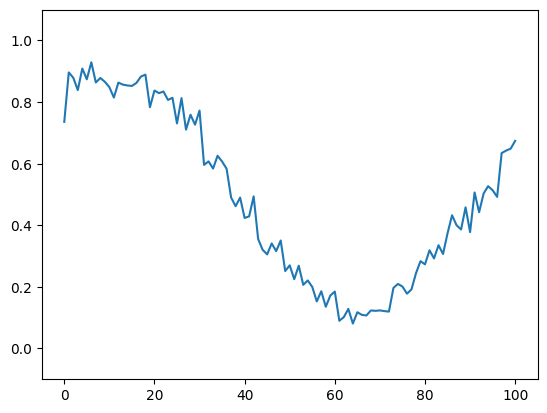

In [145]:
import matplotlib.pyplot as plt
plt.plot(processed_d['q0']['population'][1,:])
plt.ylim([-0.1, 1.1])
plt.show()

In [11]:
from laboneq_applications.analysis import iq_blobs
from laboneq_applications.experiments import iq_blobs

#######################################################################
q = qubits[0]

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = iq_blobs.experiment_workflow.options()

#print(workflow.show_fields(options))

###################################################################
iq = iq_blobs.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge'
)

iq_result = iq.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(iq_result.tasks['analysis_workflow'].output)


DRIVE range (dBm) : 10, READOUT range (dBm) : -10
[2025.09.09 17:23:30.810] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:23:30.811] INFO      Workflow 'iq_blobs': execution started at 2025-09-09 08:23:30.810605Z         
[2025.09.09 17:23:30.811] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2025.09.09 17:23:30.824] INFO    Task 'temporary_qpu': started at 2025-09-09 08:23:30.823968Z
[2025.09.09 17:23:30.825] INFO    Task 'temporary_qpu': ended at 2025-09-09 08:23:30.824976Z
[2025.09.09 17:23:30.826] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2025-09-09 
[2025.09.09 17:23:30.827] INFO    08:23:30.826836Z
[2025.09.09 17:23:30.827] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2025-09-09 08:23:30.827700Z
[2025.09.09 17:23:30.828] INFO    Task 'create_experiment': started at 2025-09-09 08:23:30.828673Z
[2025.09.09 17:23:30.833] INFO    Task 'create_expe

# Basic Readout optimization
Here we optimize SNR via

* `readout_length`
* `readout-amplitude`

* `readout_integration_length`
* `readout_integration_delay`
* `readout_integration_weight`

In [ ]:
from experiments import dispersive_shift

In [ ]:
from experiments import time_traces

# Save Qubit Parameters

In [133]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters", filename="KAIST_TG_0909")

Qubit parameters stored as JSON in /Users/yalgaeahn/JSAHN/qubit-experiment/examples/qubit_parameters/20250909-2310_KAIST_TG_0909.json


In [142]:
qubits[2].transition_parameters()

('drive',
 {'amplitude_pi': 0.2,
  'amplitude_pi2': 0.1,
  'length': 6.4e-08,
  'pulse': {'function': 'drag', 'beta': 0, 'sigma': 0.25}})